In [ ]:
import random
import h5py
import numpy as np
import math, tqdm, sys, os
import torch
import torch.nn.modules as nn
import torch.optim as optim
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # Encoder: Increased capacity with higher channel counts
        self.encoder1 = self.conv_block(3, 64)
        self.encoder2 = self.conv_block(64, 128)
        self.encoder3 = self.conv_block(128, 256)
        self.encoder4 = self.conv_block(256, 512)
        self.bottleneck = self.conv_block(512, 1024)

        # Decoder
        self.upconv4 = self.upconv(1024, 512)
        self.decoder4 = self.conv_block(1024, 512)
        self.upconv3 = self.upconv(512, 256)
        self.decoder3 = self.conv_block(512, 256)
        self.upconv2 = self.upconv(256, 128)
        self.decoder2 = self.conv_block(256, 128)
        self.upconv1 = self.upconv(128, 64)
        self.decoder1 = self.conv_block(128, 64)

        # Final output layer
        self.final = nn.Sequential(
            nn.Conv2d(64, 1, kernel_size=1),
            nn.Sigmoid()
        )

        # Max-pooling for down-sampling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def conv_block(self, in_channels, out_channels):
        """Convolutional block: Two conv layers with BatchNorm and ReLU."""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def upconv(self, in_channels, out_channels):
        """Transposed convolution for up-sampling."""
        return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

    def forward(self, x):
        # Encoder
        enc1 = self.encoder1(x)  # Output: 64 channels
        enc2 = self.encoder2(self.pool(enc1))  # Output: 128 channels
        enc3 = self.encoder3(self.pool(enc2))  # Output: 256 channels
        enc4 = self.encoder4(self.pool(enc3))  # Output: 512 channels

        # Bottleneck
        bottleneck = self.bottleneck(self.pool(enc4))  # Output: 1024 channels

        # Decoder
        dec4 = self.decoder4(torch.cat((self.upconv4(bottleneck), enc4), dim=1))  # Output: 512 channels
        dec3 = self.decoder3(torch.cat((self.upconv3(dec4), enc3), dim=1))  # Output: 256 channels
        dec2 = self.decoder2(torch.cat((self.upconv2(dec3), enc2), dim=1))  # Output: 128 channels
        dec1 = self.decoder1(torch.cat((self.upconv1(dec2), enc1), dim=1))  # Output: 64 channels

        # Final depth map
        out = self.final(dec1)
        return out

In [ ]:
class TemporalConsistencyDataset(torch.utils.data.Dataset):
    def __init__(self, images, depths, augment_fn):
        super(TemporalConsistencyDataset, self).__init__()
        self.images = images
        self.depths = depths
        self.augment_fn = augment_fn

    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, idx):
        image = self.images[idx]
        depth = self.depths[idx]

        # Apply augmentations to create "consecutive" frames
        cropped_img1, cropped_img2, cropped_depth1, cropped_depth2 = self.augment_fn(image, depth)

        # Normalize images and expand dimensions of depth
        image1 = torch.tensor(cropped_img1, dtype=torch.float32) / 255.0
        image2 = torch.tensor(cropped_img2, dtype=torch.float32) / 255.0
        depth1 = torch.tensor(np.expand_dims(cropped_depth1, axis=0), dtype=torch.float32)
        depth2 = torch.tensor(np.expand_dims(cropped_depth2, axis=0), dtype=torch.float32)
        return (image1, image2), (depth1, depth2)


def augmentation_with_brightness(image, depth, crop_fraction=0.9):
    """
    Simulates consecutive frames with random cropping of fixed size and brightness adjustment.

    Args:
        image (np.ndarray): RGB image in (C, H, W) format.
        depth (np.ndarray): Depth map in (H, W) format.
        crop_fraction (float): Fraction of the width/height to determine the crop size. Default is 10% (0.1).

    Returns:
        cropped_img1, cropped_img2, cropped_depth1, cropped_depth2
    """
    # Ensure input is in (H, W, C) format for augmentation
    if image.shape[0] == 3:  # If channel-first (C, H, W), convert to (H, W, C)
        image = np.transpose(image, (1, 2, 0))

    img = np.copy(image)
    depth_map = np.copy(depth)

    h, w, _ = img.shape

    # Calculate fixed crop dimensions
    crop_h = int(h * crop_fraction)  # Crop height
    crop_w = int(w * crop_fraction)  # Crop width

    # Ensure crops are smaller than the original dimensions
    crop_h = min(crop_h, h - 1)
    crop_w = min(crop_w, w - 1)

    # Frame 1: Random cropping starting coordinates
    start_x1 = random.randint(0, w - crop_w)
    start_y1 = random.randint(0, h - crop_h)
    end_x1 = start_x1 + crop_w
    end_y1 = start_y1 + crop_h

    cropped_img1 = img[start_y1:end_y1, start_x1:end_x1]
    cropped_depth1 = depth_map[start_y1:end_y1, start_x1:end_x1]

    # Frame 2: Different random cropping starting coordinates
    start_x2 = random.randint(0, w - crop_w)
    start_y2 = random.randint(0, h - crop_h)
    end_x2 = start_x2 + crop_w
    end_y2 = start_y2 + crop_h

    cropped_img2 = img[start_y2:end_y2, start_x2:end_x2]
    cropped_depth2 = depth_map[start_y2:end_y2, start_x2:end_x2]

    # Random brightness adjustment for RGB images only
    brightness_factor1 = random.uniform(0.8, 1.2)
    brightness_factor2 = random.uniform(0.8, 1.2)
    cropped_img1 = np.clip(cropped_img1 * brightness_factor1, 0, 255).astype(np.uint8)
    cropped_img2 = np.clip(cropped_img2 * brightness_factor2, 0, 255).astype(np.uint8)

    # Convert back to channel-first format for the cropped images
    cropped_img1 = np.transpose(cropped_img1, (2, 0, 1))
    cropped_img2 = np.transpose(cropped_img2, (2, 0, 1))

    return cropped_img1, cropped_img2, cropped_depth1, cropped_depth2

In [ ]:
# def edge_aware_smoothness_loss(predicted_depth, depth_label, rgb_image):
#     """
#     Computes edge-aware smoothness loss using both depth labels and RGB image.

#     Args:
#         predicted_depth (torch.Tensor): Predicted depth map [Batch, 1, H, W].
#         depth_label (torch.Tensor): Ground-truth depth map [Batch, 1, H, W].
#         rgb_image (torch.Tensor): RGB image [Batch, 3, H, W].

#     Returns:
#         torch.Tensor: Edge-aware smoothness loss.
#     """
#     # Compute gradients for predicted depth
#     grad_pred_x = torch.abs(predicted_depth[:, :, :-1, :] - predicted_depth[:, :, 1:, :])
#     grad_pred_y = torch.abs(predicted_depth[:, :, :, :-1] - predicted_depth[:, :, :, 1:])

#     # Compute gradients for ground-truth depth labels
#     grad_label_x = torch.abs(depth_label[:, :, :-1, :] - depth_label[:, :, 1:, :])
#     grad_label_y = torch.abs(depth_label[:, :, :, :-1] - depth_label[:, :, :, 1:])

#     # Compute image gradients (average over RGB channels)
#     grad_image_x = torch.mean(torch.abs(rgb_image[:, :, :-1, :] - rgb_image[:, :, 1:, :]), dim=1, keepdim=True)
#     grad_image_y = torch.mean(torch.abs(rgb_image[:, :, :, :-1] - rgb_image[:, :, :, 1:]), dim=1, keepdim=True)

#     # Compute weights (higher weights for smooth regions in the RGB image)
#     weight_x = torch.exp(-grad_image_x)
#     weight_y = torch.exp(-grad_image_y)

#     # Weighted smoothness loss (difference between predicted and label depth gradients)
#     smoothness_x = weight_x * torch.abs(grad_pred_x - grad_label_x)
#     smoothness_y = weight_y * torch.abs(grad_pred_y - grad_label_y)

#     # Combine losses
#     return smoothness_x.mean() + smoothness_y.mean()

def compute_gradient(tensor, direction):
    """
    Computes gradients of a tensor along the specified direction.

    Args:
        tensor: Input tensor of shape [B, C, H, W].
        direction: Direction for gradient computation, either 'x' or 'y'.

    Returns:
        Tensor of gradients in the specified direction.
    """
    if direction == 'x':
        return tensor[:, :, :, :-1] - tensor[:, :, :, 1:]
    elif direction == 'y':
        return tensor[:, :, :-1, :] - tensor[:, :, 1:, :]
    else:
        raise ValueError("Invalid direction. Use 'x' or 'y'.")

def supervised_edge_aware_smoothness_loss(predicted, depth_label, lambda_edge=10.0):
    """
    Computes supervised edge-aware smoothness loss using depth labels.

    Args:
        predicted: Predicted depth map of shape [B, 1, H, W].
        depth_label: Ground-truth depth map of shape [B, 1, H, W].
        lambda_edge: Edge sensitivity scaling factor.

    Returns:
        Edge-aware smoothness loss as a scalar.
    """
    # Compute gradients of the depth labels
    label_grad_x = compute_gradient(depth_label, direction='x')
    label_grad_y = compute_gradient(depth_label, direction='y')

    # Compute gradients of the predicted depth
    pred_grad_x = compute_gradient(predicted, direction='x')
    pred_grad_y = compute_gradient(predicted, direction='y')

    # Compute edge-aware weights from depth label gradients
    weight_x = torch.exp(-lambda_edge * torch.abs(label_grad_x))
    weight_y = torch.exp(-lambda_edge * torch.abs(label_grad_y))

    # Compute edge-aware smoothness loss
    loss_x = torch.mean(weight_x * torch.abs(pred_grad_x))
    loss_y = torch.mean(weight_y * torch.abs(pred_grad_y))

    return loss_x + loss_y


def combined_loss(pred_depth1, pred_depth2, depth1, depth2, rgb_image1, rgb_image2, lambda_temporal=0.1, lambda_smooth=0.1):
    """
    Combines depth estimation loss, temporal consistency loss, and edge-aware smoothness loss.

    Args:
        pred_depth1 (torch.Tensor): Predicted depth map for image1.
        pred_depth2 (torch.Tensor): Predicted depth map for image2.
        depth1 (torch.Tensor): Ground-truth depth map for image1.
        depth2 (torch.Tensor): Ground-truth depth map for image2.
        rgb_image1 (torch.Tensor): RGB image corresponding to depth1.
        rgb_image2 (torch.Tensor): RGB image corresponding to depth2.
        lambda_temporal (float): Weight for the temporal consistency loss.
        lambda_smooth (float): Weight for the edge-aware smoothness loss.

    Returns:
        torch.Tensor: Combined loss value.
    """
    # Depth Estimation Loss (MSE between predictions and ground truth)
    depth_loss = torch.nn.functional.mse_loss(pred_depth1, depth1) + \
                 torch.nn.functional.mse_loss(pred_depth2, depth2)

    # Temporal Consistency Loss (MSE between consecutive predicted depths)
    temporal_consistency_loss = torch.nn.functional.mse_loss(pred_depth1, pred_depth2)

    # Edge-Aware Smoothness Loss
    smoothness_loss1 = supervised_edge_aware_smoothness_loss(pred_depth1, depth1)
    smoothness_loss2 = supervised_edge_aware_smoothness_loss(pred_depth2, depth2)
    smoothness_loss = smoothness_loss1 + smoothness_loss2

    # Combined loss
    total_loss = depth_loss + lambda_temporal * temporal_consistency_loss + lambda_smooth * smoothness_loss
    return total_loss


In [ ]:
def train_temporal(model, train_loader, valid_loader, criterion, optimizer, device, epochs=10, lambda_temporal=0.1):
    """
    Trains a depth estimation model with temporal consistency.

    Args:
        model (torch.nn.Module): The U-Net model.
        train_loader (DataLoader): Training data loader.
        valid_loader (DataLoader): Validation data loader.
        criterion (function): Loss function combining depth estimation and temporal consistency.
        optimizer (torch.optim.Optimizer): Optimizer for training.
        device (torch.device): Device for computation.
        epochs (int): Number of training epochs.
        lambda_temporal (float): Weight for temporal consistency loss.

    Returns:
        None
    """
    model.to(device)
    train_losses = []
    valid_losses = []

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0
        print(f"Train epoch {epoch + 1}/{epochs}")

        for (images1, images2), (depth1, depth2) in tqdm.tqdm(train_loader):
            # Move data to the device
            images1, images2 = images1.to(device), images2.to(device)
            depth1, depth2 = depth1.to(device), depth2.to(device)

            optimizer.zero_grad()

            # Forward pass for both frames
            outputs1 = model(images1)
            outputs2 = model(images2)

            # Compute loss
            loss = combined_loss(outputs1, outputs2, depth1, depth2, images1, images2, lambda_temporal=0.1, lambda_smooth=0.1)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)

        # Validation phase
        model.eval()
        valid_loss = 0
        print(f"Validation epoch {epoch + 1}/{epochs}")
        with torch.no_grad():
            for (images1, images2), (depth1, depth2) in tqdm.tqdm(valid_loader):
                # Move data to the device
                images1, images2 = images1.to(device), images2.to(device)
                depth1, depth2 = depth1.to(device), depth2.to(device)

                # Forward pass for both frames
                outputs1 = model(images1)
                outputs2 = model(images2)

                # Compute validation loss
                loss = combined_loss(outputs1, outputs2, depth1, depth2, images1, images2, lambda_temporal=0.4, lambda_smooth=1)
                valid_loss += loss.item()

        valid_loss /= len(valid_loader)
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        # Logging
        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}")
        if (epoch + 1) > 20 and epoch % 5 == 0:
        # Save model checkpoint
          torch.save(model.state_dict(), f"/content/gdrive/MyDrive/ECE_1508_project/supervised_edge_aware_temporal_smooth_1_epoch_{epoch + 1}.pth")
    return train_losses, valid_losses

In [ ]:
#/content/gdrive/MyDrive/ECE_1508_project/nyu_depth_v2_labeled.mat
print("Loading dataset for temporal consistency training...")
with h5py.File('/content/gdrive/MyDrive/ECE_1508_project/nyu_depth_v2_labeled.mat', 'r') as f:
    images = f['images'][:]
    depths = f['depths'][:]

Loading dataset for temporal consistency training...


In [ ]:
# Check range
min_depth = np.min(depths)
max_depth = np.max(depths)

print(f"Minimum depth value: {min_depth}")
print(f"Maximum depth value: {max_depth}")

Minimum depth value: 0.7132995128631592
Maximum depth value: 9.99547004699707


In [ ]:
depths = depths / 10

In [ ]:
test_num = 200
batch_size = 4
train_dataset = TemporalConsistencyDataset(images[test_num:], depths[test_num:], augmentation_with_brightness)
valid_dataset = TemporalConsistencyDataset(images[:test_num], depths[:test_num], augmentation_with_brightness)

# Create DataLoader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Model, loss, optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet()
optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-4)
criterion = combined_loss

In [14]:
# Train the model
train_losses, valid_losses = train_temporal(model, train_loader, valid_loader, criterion, optimizer, device, epochs=30, lambda_temporal=0.1)

Train epoch 1/30


100%|██████████| 313/313 [09:40<00:00,  1.85s/it]


Validation epoch 1/30


100%|██████████| 50/50 [00:34<00:00,  1.43it/s]


Epoch 1/30, Train Loss: 0.0894, Valid Loss: 0.1385
Train epoch 2/30


100%|██████████| 313/313 [09:39<00:00,  1.85s/it]


Validation epoch 2/30


100%|██████████| 50/50 [00:34<00:00,  1.44it/s]


Epoch 2/30, Train Loss: 0.0463, Valid Loss: 0.1167
Train epoch 3/30


100%|██████████| 313/313 [09:39<00:00,  1.85s/it]


Validation epoch 3/30


100%|██████████| 50/50 [00:34<00:00,  1.44it/s]


Epoch 3/30, Train Loss: 0.0427, Valid Loss: 0.0811
Train epoch 4/30


100%|██████████| 313/313 [09:39<00:00,  1.85s/it]


Validation epoch 4/30


100%|██████████| 50/50 [00:34<00:00,  1.45it/s]


Epoch 4/30, Train Loss: 0.0397, Valid Loss: 0.0739
Train epoch 5/30


100%|██████████| 313/313 [09:38<00:00,  1.85s/it]


Validation epoch 5/30


100%|██████████| 50/50 [00:34<00:00,  1.44it/s]


Epoch 5/30, Train Loss: 0.0369, Valid Loss: 0.0877
Train epoch 6/30


100%|██████████| 313/313 [09:39<00:00,  1.85s/it]


Validation epoch 6/30


100%|██████████| 50/50 [00:34<00:00,  1.44it/s]


Epoch 6/30, Train Loss: 0.0349, Valid Loss: 0.0668
Train epoch 7/30


100%|██████████| 313/313 [09:40<00:00,  1.85s/it]


Validation epoch 7/30


100%|██████████| 50/50 [00:34<00:00,  1.43it/s]


Epoch 7/30, Train Loss: 0.0339, Valid Loss: 0.0655
Train epoch 8/30


100%|██████████| 313/313 [09:39<00:00,  1.85s/it]


Validation epoch 8/30


100%|██████████| 50/50 [00:34<00:00,  1.45it/s]


Epoch 8/30, Train Loss: 0.0328, Valid Loss: 0.0685
Train epoch 9/30


100%|██████████| 313/313 [09:39<00:00,  1.85s/it]


Validation epoch 9/30


100%|██████████| 50/50 [00:34<00:00,  1.45it/s]


Epoch 9/30, Train Loss: 0.0318, Valid Loss: 0.0657
Train epoch 10/30


100%|██████████| 313/313 [09:40<00:00,  1.85s/it]


Validation epoch 10/30


100%|██████████| 50/50 [00:34<00:00,  1.44it/s]


Epoch 10/30, Train Loss: 0.0314, Valid Loss: 0.0608
Train epoch 11/30


100%|██████████| 313/313 [09:38<00:00,  1.85s/it]


Validation epoch 11/30


100%|██████████| 50/50 [00:34<00:00,  1.43it/s]


Epoch 11/30, Train Loss: 0.0316, Valid Loss: 0.0635
Train epoch 12/30


100%|██████████| 313/313 [09:40<00:00,  1.85s/it]


Validation epoch 12/30


100%|██████████| 50/50 [00:34<00:00,  1.44it/s]


Epoch 12/30, Train Loss: 0.0304, Valid Loss: 0.0592
Train epoch 13/30


100%|██████████| 313/313 [09:39<00:00,  1.85s/it]


Validation epoch 13/30


100%|██████████| 50/50 [00:34<00:00,  1.44it/s]


Epoch 13/30, Train Loss: 0.0300, Valid Loss: 0.0534
Train epoch 14/30


100%|██████████| 313/313 [09:39<00:00,  1.85s/it]


Validation epoch 14/30


100%|██████████| 50/50 [00:34<00:00,  1.44it/s]


Epoch 14/30, Train Loss: 0.0294, Valid Loss: 0.0627
Train epoch 15/30


100%|██████████| 313/313 [09:39<00:00,  1.85s/it]


Validation epoch 15/30


100%|██████████| 50/50 [00:34<00:00,  1.44it/s]


Epoch 15/30, Train Loss: 0.0288, Valid Loss: 0.0571
Train epoch 16/30


100%|██████████| 313/313 [09:39<00:00,  1.85s/it]


Validation epoch 16/30


100%|██████████| 50/50 [00:34<00:00,  1.45it/s]


Epoch 16/30, Train Loss: 0.0283, Valid Loss: 0.0843
Train epoch 17/30


100%|██████████| 313/313 [09:37<00:00,  1.85s/it]


Validation epoch 17/30


100%|██████████| 50/50 [00:34<00:00,  1.45it/s]


Epoch 17/30, Train Loss: 0.0279, Valid Loss: 0.0541
Train epoch 18/30


100%|██████████| 313/313 [09:38<00:00,  1.85s/it]


Validation epoch 18/30


100%|██████████| 50/50 [00:34<00:00,  1.45it/s]


Epoch 18/30, Train Loss: 0.0276, Valid Loss: 0.0510
Train epoch 19/30


100%|██████████| 313/313 [09:37<00:00,  1.85s/it]


Validation epoch 19/30


100%|██████████| 50/50 [00:34<00:00,  1.45it/s]


Epoch 19/30, Train Loss: 0.0271, Valid Loss: 0.0515
Train epoch 20/30


100%|██████████| 313/313 [09:38<00:00,  1.85s/it]


Validation epoch 20/30


100%|██████████| 50/50 [00:34<00:00,  1.44it/s]


Epoch 20/30, Train Loss: 0.0269, Valid Loss: 0.0658
Train epoch 21/30


100%|██████████| 313/313 [09:40<00:00,  1.85s/it]


Validation epoch 21/30


100%|██████████| 50/50 [00:34<00:00,  1.43it/s]


Epoch 21/30, Train Loss: 0.0268, Valid Loss: 0.0503
Train epoch 22/30


100%|██████████| 313/313 [09:40<00:00,  1.86s/it]


Validation epoch 22/30


100%|██████████| 50/50 [00:34<00:00,  1.44it/s]


Epoch 22/30, Train Loss: 0.0263, Valid Loss: 0.0662
Train epoch 23/30


100%|██████████| 313/313 [09:39<00:00,  1.85s/it]


Validation epoch 23/30


100%|██████████| 50/50 [00:34<00:00,  1.44it/s]


Epoch 23/30, Train Loss: 0.0256, Valid Loss: 0.0635
Train epoch 24/30


100%|██████████| 313/313 [09:39<00:00,  1.85s/it]


Validation epoch 24/30


100%|██████████| 50/50 [00:34<00:00,  1.44it/s]


Epoch 24/30, Train Loss: 0.0255, Valid Loss: 0.0528
Train epoch 25/30


100%|██████████| 313/313 [09:39<00:00,  1.85s/it]


Validation epoch 25/30


100%|██████████| 50/50 [00:34<00:00,  1.44it/s]


Epoch 25/30, Train Loss: 0.0251, Valid Loss: 0.0502
Train epoch 26/30


100%|██████████| 313/313 [09:39<00:00,  1.85s/it]


Validation epoch 26/30


100%|██████████| 50/50 [00:34<00:00,  1.44it/s]


Epoch 26/30, Train Loss: 0.0251, Valid Loss: 0.0522
Train epoch 27/30


100%|██████████| 313/313 [09:40<00:00,  1.85s/it]


Validation epoch 27/30


100%|██████████| 50/50 [00:34<00:00,  1.44it/s]


Epoch 27/30, Train Loss: 0.0245, Valid Loss: 0.0486
Train epoch 28/30


100%|██████████| 313/313 [09:39<00:00,  1.85s/it]


Validation epoch 28/30


100%|██████████| 50/50 [00:34<00:00,  1.44it/s]


Epoch 28/30, Train Loss: 0.0244, Valid Loss: 0.0546
Train epoch 29/30


100%|██████████| 313/313 [09:39<00:00,  1.85s/it]


Validation epoch 29/30


100%|██████████| 50/50 [00:34<00:00,  1.44it/s]


Epoch 29/30, Train Loss: 0.0237, Valid Loss: 0.0467
Train epoch 30/30


100%|██████████| 313/313 [09:39<00:00,  1.85s/it]


Validation epoch 30/30


100%|██████████| 50/50 [00:34<00:00,  1.44it/s]

Epoch 30/30, Train Loss: 0.0240, Valid Loss: 0.0501


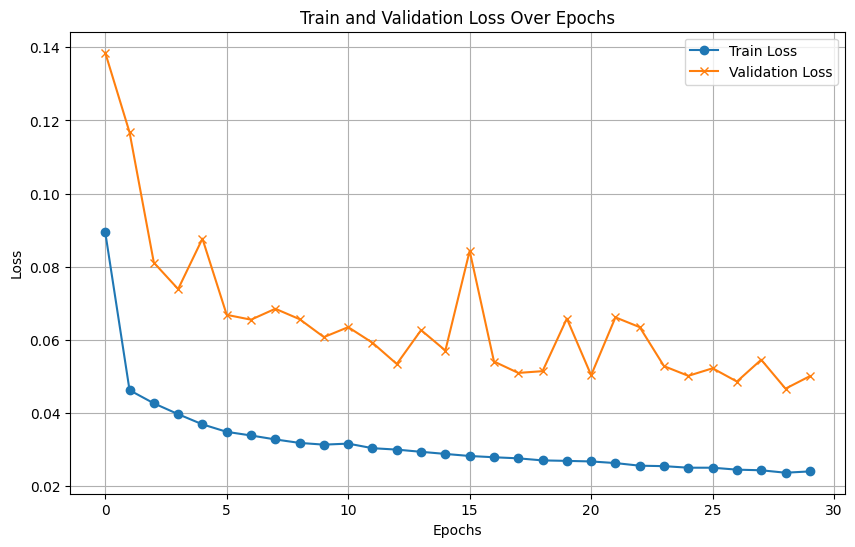

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Train Loss", marker='o')
plt.plot(valid_losses, label="Validation Loss", marker='x')
plt.title("Train and Validation Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
model1 = UNet()
checkpoint = torch.load("/content/gdrive/MyDrive/ECE_1508_project/supervised_edge_aware_temporal_smooth_1_epoch_21.pth")
model1.load_state_dict(checkpoint)
model1.to(device)

<ipython-input-11-5f7b61bf94e3>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("/content/gdrive/MyDrive/ECE_1508_project/supervised_edge_aware_temp

UNet(
  (encoder1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (encoder2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (encoder3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=T

In [ ]:
model2 = UNet()
checkpoint = torch.load("/content/gdrive/MyDrive/ECE_1508_project/epoch_149.pth")
model2.load_state_dict(checkpoint)
model2.to(device)

<ipython-input-45-b017353995f1>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("/content/gdrive/MyDrive/ECE_1508_project/epoch_149.pth")


UNet(
  (encoder1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (encoder2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (encoder3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, t

In [ ]:
def visualize_predictions(pred_depth1, pred_depth2):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title("Predicted Depth 1")
    plt.imshow(pred_depth1.cpu().detach().numpy(), cmap='viridis')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Predicted Depth 2")
    plt.imshow(pred_depth2.cpu().detach().numpy(), cmap='viridis')
    plt.axis('off')

    plt.show()

torch.Size([576, 432])
torch.Size([576, 432])


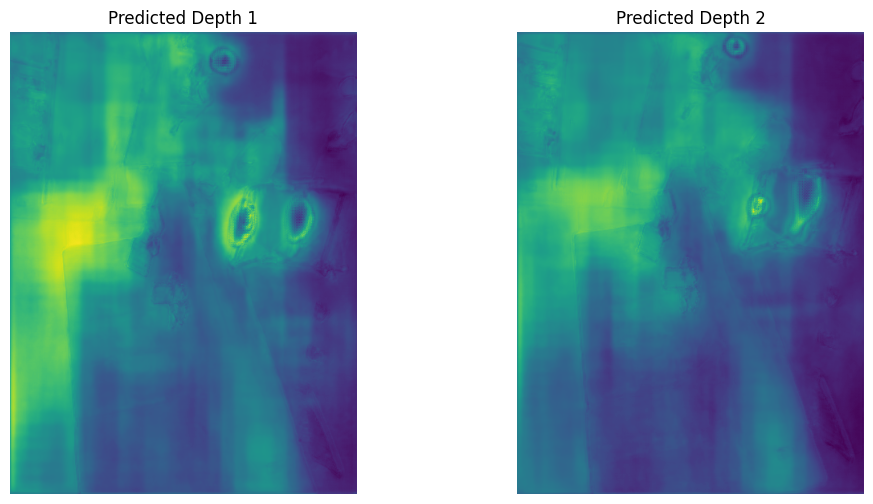

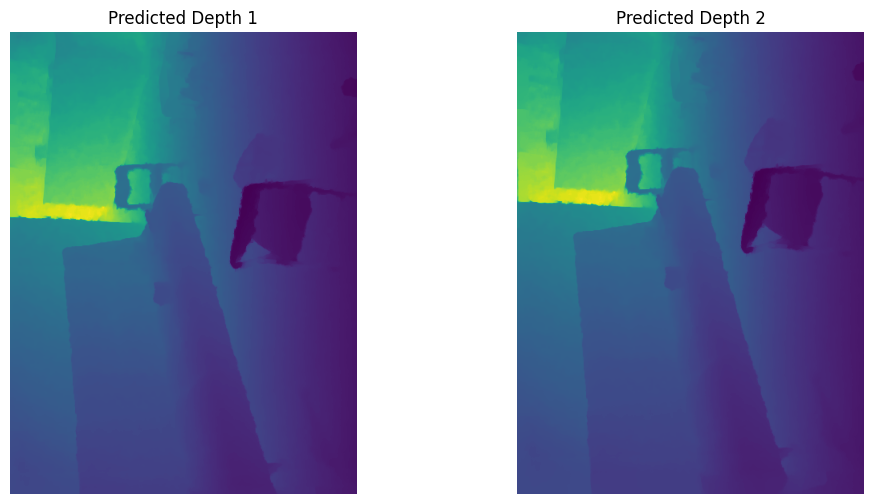

torch.Size([576, 432])
torch.Size([576, 432])


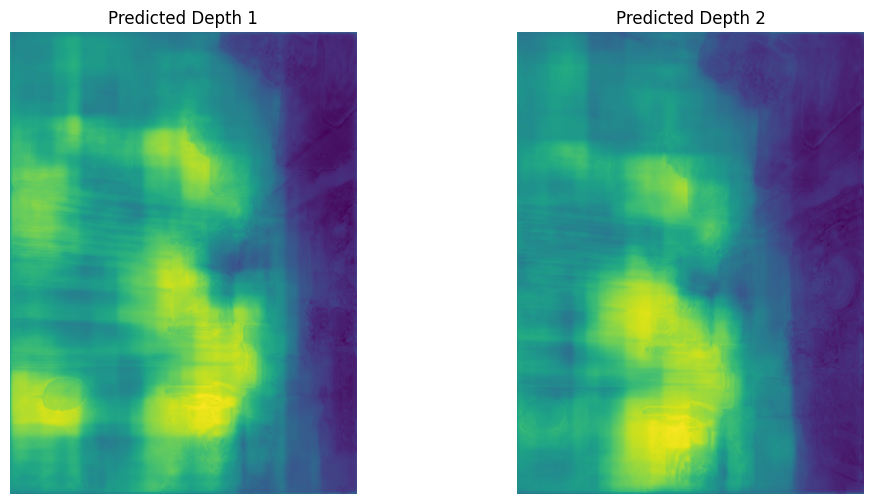

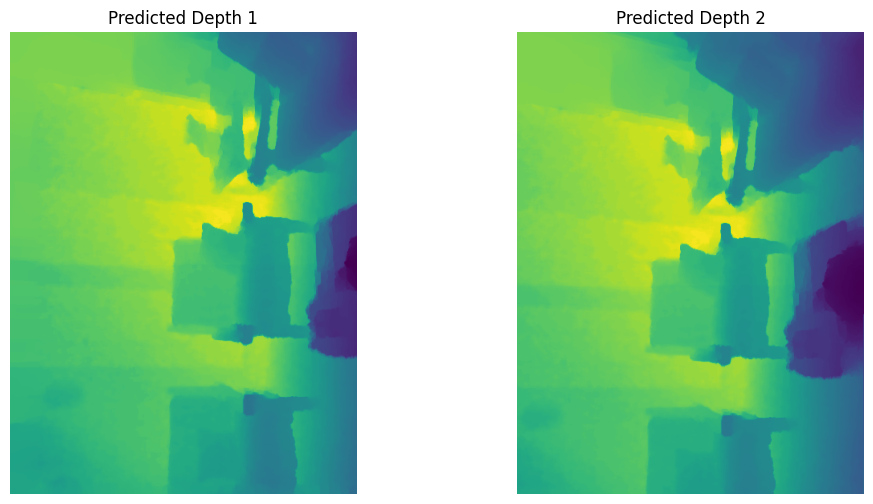

torch.Size([576, 432])
torch.Size([576, 432])


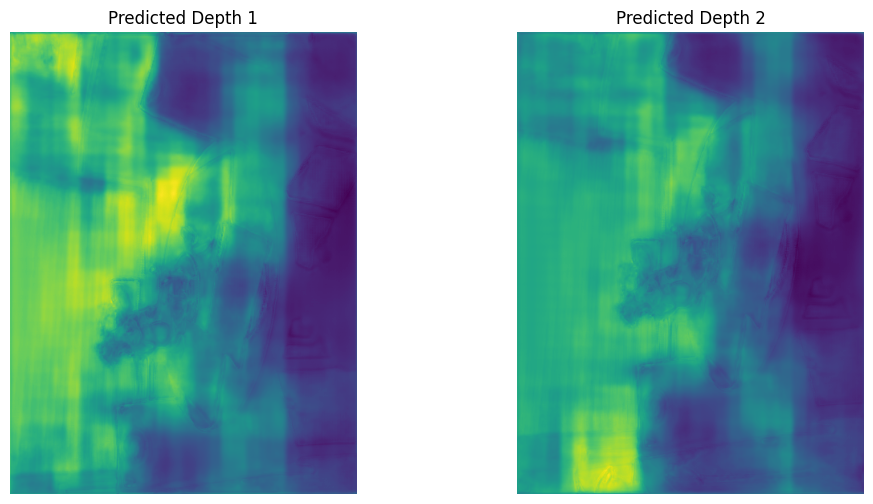

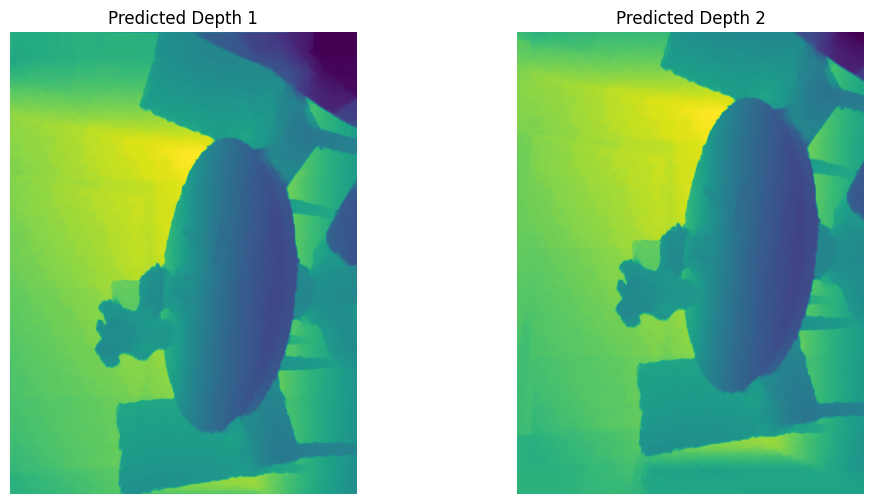

torch.Size([576, 432])
torch.Size([576, 432])


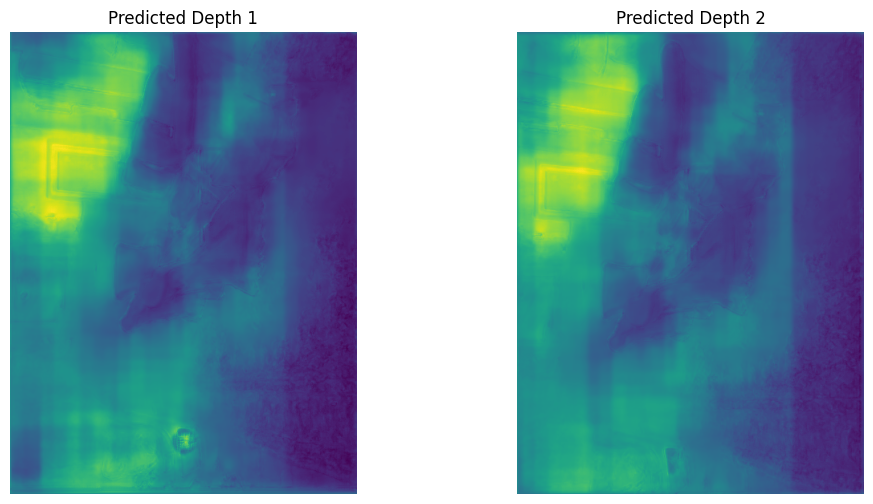

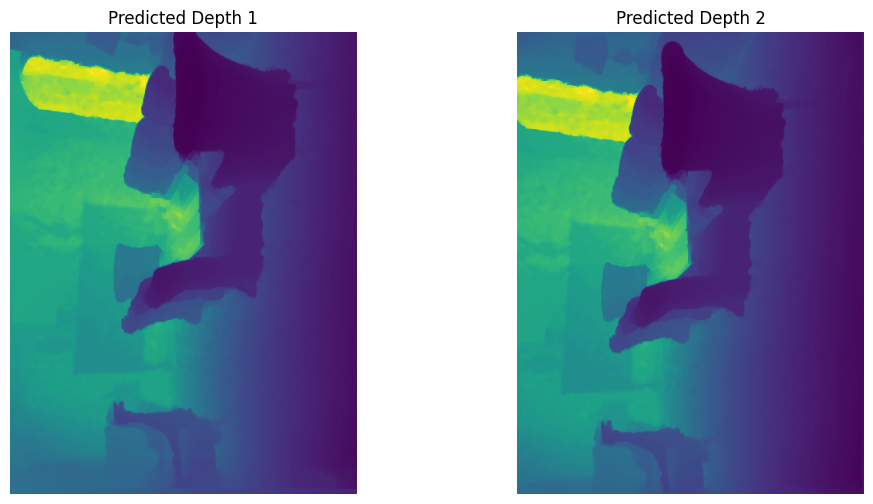

In [ ]:
with torch.no_grad():
  for (images1, images2), (depth1, depth2) in train_loader:
    images1, images2 = images1.to(device), images2.to(device)
    depth1, depth2 = depth1.to(device), depth2.to(device)

    # Forward pass for both frames
    outputs1 = model1(images1)
    outputs2 = model1(images2)

    for i in range(4):
      print(outputs1[i][0].shape)
      print(outputs2[i][0].shape)
      visualize_predictions(outputs1[i][0], outputs2[i][0])
      visualize_predictions(depth1[i][0], depth2[i][0])
      # visualize_predictions(images1[i].transpose(1, 2, 0), images2[i].transpose(1, 2, 0))
    break



In [ ]:
for (images1, images2), (depth1, depth2) in train_loader:
  images1, images2 = images1.to(device), images2.to(device)
  depth1, depth2 = depth1.to(device), depth2.to(device)
  outputs1 = model1(images1)
  outputs2 = model2(images1)
  print('model1')
  print(depth1[0][0].max())
  print(outputs1[0][0].max())
  print('model2')
  print(depth1[0][0].max())
  print(outputs2[0][0].max())
  break

model1
tensor(4.0475, device='cuda:0')
tensor(4.7408, device='cuda:0', grad_fn=<MaxBackward1>)
model2
tensor(4.0475, device='cuda:0')
tensor(5.7469, device='cuda:0', grad_fn=<MaxBackward1>)
